# **First** autoencoder

## Importing data

In [74]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from sklearn.decomposition import PCA

from DATA_generator import *

%matplotlib inline
import matplotlib.pyplot as plt



#using lorenzos code from R
#import rpy2.robjects as robjects
#from rpy2.robjects import pandas2ri

Real DATA

In [75]:
bigData = pd.read_csv("/home/salati/CHIRAL/Pkg/CHIRAL/Example/Muscle_exon.txt", sep=" ")
#Taking only the rythmic genes
PeriodicData=bigData.loc[["ENSG00000105516", "ENSG00000049246", "ENSG00000167074", "ENSG00000174738", "ENSG00000179094", "ENSG00000132326" , "ENSG00000170485", "ENSG00000133794","ENSG00000126368","ENSG00000008405","ENSG00000121671","ENSG00000159208"]]
DATA=torch.tensor(PeriodicData.values)
DATA=DATA.float()
E=np.array(PeriodicData.values)

true_phases=pd.read_csv("/home/salati/CHIRAL/Pkg/CHIRAL/Example/true_phi.txt",sep=" ")
true_phases=np.array(true_phases.values)
true_phases=true_phases[:,0]

Simulated DATA

N_Samples=56
N_PeriodicGenes=12
N_NonPeriodicGenes=0
N_Genes=N_PeriodicGenes+N_NonPeriodicGenes
NoiseSigma=0.04

#E , true_phases, alpha=NonUniformDataGenerator(N_Samples=N_Samples, N_PeriodicGenes=N_PeriodicGenes,noise=True, N_NonPeriodicGenes=N_NonPeriodicGenes )
E , true_phases, alpha=DataGenerator(N_Samples=N_Samples, N_PeriodicGenes=N_PeriodicGenes,noise=True, N_NonPeriodicGenes=N_NonPeriodicGenes , Means=False, NoiseSigma=NoiseSigma )

DATA=torch.from_numpy(E)
DATA=DATA.float()

In [76]:
N_Genes=DATA.shape[0]
N_Samples=DATA.shape[1]
N_Samples

57

Select gene you are interested setting varaible g in order to plot data, and supposed distribution

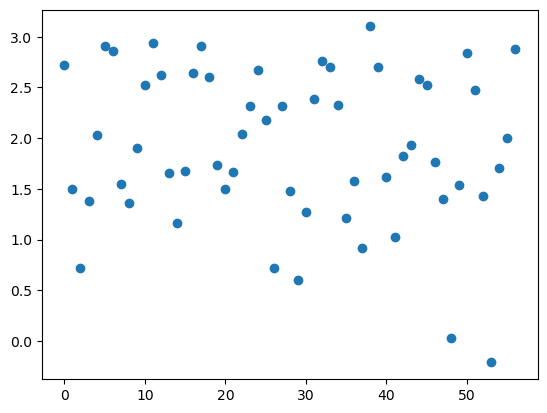

In [77]:
plt.plot(DATA[1,:], 'o')

## PCA

In [78]:
Et=np.transpose(E)
pca=PCA(n_components=2)
pca.fit(Et)

PCA(n_components=2)

In [79]:
pca.explained_variance_ratio_
PCA_base=pca.components_
PCA_base=np.array(PCA_base)
print('The two vectors are orthogonal, the scalar priduct is: ',np.matmul(PCA_base[0,:] ,PCA_base[1,:]) )


The two vectors are orthogonal, the scalar priduct is:  -2.7755575615628914e-17


In [80]:
pca_points=pca.fit_transform(Et)

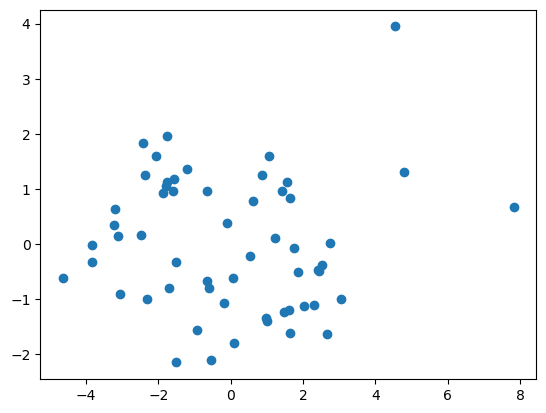

In [81]:
plt.plot(pca_points[:,0] , pca_points[:,1], 'o')

In [82]:
from DATA_generator import *
PCA_phi=np.arctan2(pca_points[:,0],pca_points[:,1])
PCAshifted_phi,madPCA=optimal_shift(PCA_phi, true_phases)
madPCA

0.33878580216854104

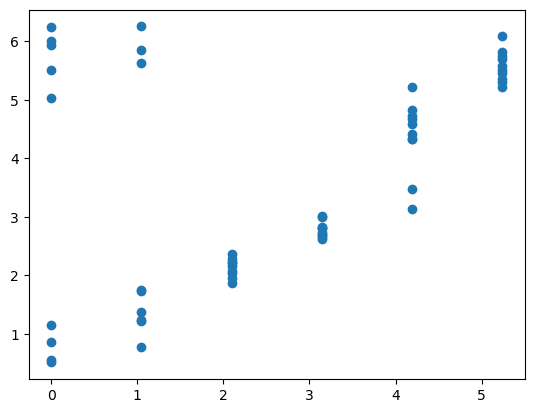

In [83]:
plt.plot(true_phases,PCAshifted_phi, 'o')

## Torch Linear

### Setting the network

In [84]:
PCA_tensor=torch.tensor(PCA_base)
PCA_tensor=PCA_tensor.float()
PCA_tensor

tensor([[-0.3415, -0.2836, -0.3255, -0.2395, -0.4008, -0.2304,  0.0701,  0.2681,
         -0.2792,  0.0499, -0.1431, -0.4982],
        [ 0.0096,  0.1267,  0.0540, -0.1128,  0.0749, -0.0783, -0.4529, -0.3995,
         -0.7616, -0.0944,  0.0129,  0.0511]])

In [85]:
class LinearEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(N_Genes, 2,bias=False)
        #self.encoder.weight=nn.Parameter(PCA_tensor)

        self.decoder = nn.Linear(2, N_Genes,bias=False)
        #self.decoder.weight=nn.Parameter(PCA_tensor.transpose(0,1))
           
    #fucntion that makes the input flow in the network
    def forward(self, x):
        encoded=self.encoder(x) #compress the input
        decoded=self.decoder(encoded)

        return decoded

Here I create an instance of the class LinearEncoder and define other important stuff like the loss function

In [86]:
model = LinearEncoder()
criterion= nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(),lr=0.00001)
optimizer=torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


Adding the GPU stuff

In [87]:
#for GPU use this block

#device = torch.device('mps')
#E_t=torch.from_numpy(E)
#E_t=E_t.float()
#DATA=torch.tensor(E_t,  device=device)
#model.to(device)


# for CPU keep this line

Training cycle

In [88]:
#recon= reconstruction of the input
num_epochs=600
outputs=[]

for epoch in range(num_epochs):
 
  for sample in range(N_Samples):
    input=DATA[:,sample]
    recon=model(input)
    loss=criterion(recon,input)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #added this line to compare with the circular model, thisline block the convergence
  if loss.item() < 0.0005 :
    break
  if (epoch % 30 ==0):
    print("epoch ",epoch,"Loss", loss.item())

epoch  0 Loss 6.633520126342773
epoch  30 Loss 0.43687281012535095
epoch  60 Loss 0.4142420291900635
epoch  90 Loss 0.36297234892845154
epoch  120 Loss 0.2693709135055542
epoch  150 Loss 0.16273576021194458
epoch  180 Loss 0.09855920821428299
epoch  210 Loss 0.07115490734577179
epoch  240 Loss 0.05954655632376671
epoch  270 Loss 0.054416757076978683
epoch  300 Loss 0.05203637853264809
epoch  330 Loss 0.05089567229151726
epoch  360 Loss 0.05033594369888306
epoch  390 Loss 0.05005601420998573
epoch  420 Loss 0.04991748556494713
epoch  450 Loss 0.04985223338007927
epoch  480 Loss 0.04982687905430794
epoch  510 Loss 0.04982396960258484
epoch  540 Loss 0.04983349144458771
epoch  570 Loss 0.04985003545880318


Grabbing the weights of the first layer which are the analogous of the eigenvectors in PCA

In [89]:
encoder_base=model.encoder.weight
#print(encoder_base)
decoder_base=model.decoder.weight
#print(decoder_base)

Checking how the scalar product of the two vectors of the "basis" is

In [90]:
torch.dot(encoder_base[0,:],encoder_base[1,:] )

tensor(-0.0051, grad_fn=<DotBackward0>)

In [91]:
NNphases=np.zeros((N_Samples,2))
for sample in range(N_Samples):
  temp=torch.matmul(encoder_base, DATA[:,sample]).detach().numpy()
  NNphases[sample,:]=temp

### Plots

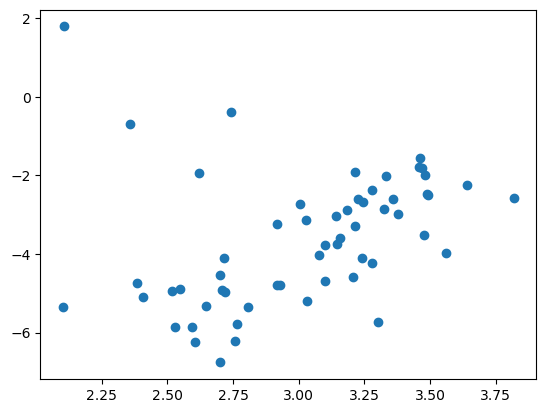

In [92]:
plt.plot(NNphases[:,0], NNphases[:,1],'o')

In [93]:
inf_phases=np.arctan2( NNphases[:,0],NNphases[:,1] )
NNshifted_phi,madNN=optimal_shift(inf_phases, true_phases)
madNN

0.8635016232681889

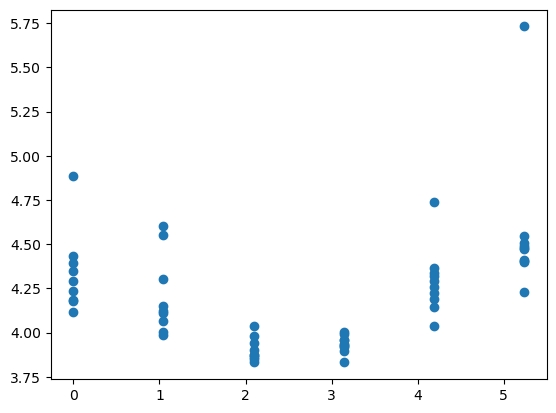

In [94]:
plt.plot(true_phases,NNshifted_phi,'o')

## Adding the "circular" activation function

### Setting the network

In [95]:
#SAME THING BUT USING SEQUENTIAL
'''
class CircularEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(N_Genes, 2,bias=False)
           )
        self.decoder = nn.Sequential(
            nn.Linear(2, N_Genes,bias=False)
           )
    #fucntion that makes the input flow in the network
    def forward(self, x):
        encoded=self.encoder(x) #compress the input
        encoded_circ=encoded/torch.linalg.norm(encoded)
        decoded=self.decoder(encoded_circ)

        return decoded #encoded,encoded_circ 
        '''

'\nclass CircularEncoder(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.encoder = nn.Sequential(\n            nn.Linear(N_Genes, 2,bias=False)\n           )\n        self.decoder = nn.Sequential(\n            nn.Linear(2, N_Genes,bias=False)\n           )\n    #fucntion that makes the input flow in the network\n    def forward(self, x):\n        encoded=self.encoder(x) #compress the input\n        encoded_circ=encoded/torch.linalg.norm(encoded)\n        decoded=self.decoder(encoded_circ)\n\n        return decoded #encoded,encoded_circ \n        '

In [96]:
class CircularEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(N_Genes, 2,bias=False)
        #self.encoder.weight=nn.Parameter(PCA_tensor)

        self.decoder = nn.Linear(2, N_Genes,bias=False)
        #self.decoder.weight=nn.Parameter(PCA_tensor.transpose(0,1))
    
    #fucntion that makes the input flow in the network
    def forward(self, x):
        encoded=self.encoder(x) #compress the input
        encoded_circ=encoded/torch.linalg.norm(encoded)

        decoded=self.decoder(encoded_circ)

        return decoded #encoded,encoded_circ 

In [97]:
circ_model=CircularEncoder()
criterion2= nn.MSELoss()
optimizer2 = torch.optim.Adam(circ_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer2 = torch.optim.SGD(circ_model.parameters(),lr=0.001)


In [98]:
#recon= reconstruction of the input
num_epochs=300
outputs=[]

for epoch in range(num_epochs):
  for sample in range(N_Samples):
    input=DATA[:,sample]
    recon=circ_model(input)
    loss=criterion2(recon,input)

    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()
  if (epoch % 10 ==0):
    print("epoch ",epoch,"Loss", loss.item())

epoch  0 Loss 6.476596832275391
epoch  10 Loss 4.079363822937012
epoch  20 Loss 2.647115468978882
epoch  30 Loss 1.75722074508667
epoch  40 Loss 1.1904946565628052
epoch  50 Loss 0.817620575428009
epoch  60 Loss 0.5652506947517395
epoch  70 Loss 0.39332273602485657
epoch  80 Loss 0.2774408757686615
epoch  90 Loss 0.20116496086120605
epoch  100 Loss 0.1523168832063675
epoch  110 Loss 0.12171480804681778
epoch  120 Loss 0.10273879766464233
epoch  130 Loss 0.0909000039100647
epoch  140 Loss 0.0833219364285469
epoch  150 Loss 0.07825179398059845
epoch  160 Loss 0.07467629015445709
epoch  170 Loss 0.07203079015016556
epoch  180 Loss 0.07000360637903214
epoch  190 Loss 0.06841607391834259
epoch  200 Loss 0.06716004759073257
epoch  210 Loss 0.06616375595331192
epoch  220 Loss 0.06537541002035141
epoch  230 Loss 0.06475623697042465
epoch  240 Loss 0.06427585333585739
epoch  250 Loss 0.06391007453203201
epoch  260 Loss 0.06363912671804428
epoch  270 Loss 0.06344594806432724
epoch  280 Loss 0.06

In [99]:
circ_encoder_base=circ_model.encoder.weight
print(encoder_base)
circ_decoder_baseC=circ_model.decoder.weight
#print(decoder_base)


Parameter containing:
tensor([[-0.1396,  0.0369,  0.0852,  0.3022,  0.0234,  0.0015, -0.0669,  0.2685,
          0.1342,  0.1128,  0.3236, -0.2644],
        [-0.2172, -0.2147, -0.2300, -0.2018, -0.2741, -0.1522,  0.0908,  0.1839,
         -0.1685,  0.0154, -0.1404, -0.3127]], requires_grad=True)


After having the values of the weight, in order to find the values of the neurons, i just reconstruct waht happens to the input until the the bottle neck (encoder linear layer + unit circle projection)

In [100]:
NNphasesC=np.zeros((2,N_Samples))
for sample in range(N_Samples):
  temp=torch.matmul(circ_encoder_base, DATA[:,sample]).detach().numpy()
  NNphasesC[:,sample]=temp
  NNphasesC[:,sample] /= np.linalg.norm(NNphasesC[:,sample])


### Plots

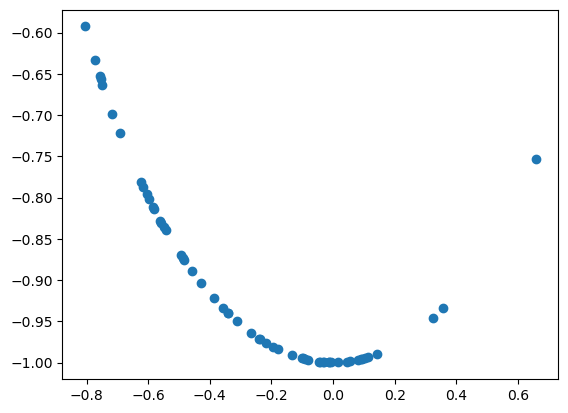

In [101]:
plt.plot(NNphasesC[0,:], NNphasesC[1,:],'o')

In [102]:
inf_phasesC=np.arctan2( NNphasesC[0,:],NNphasesC[1,:] )

NNshifted_phiC,madNNC=optimal_shift(inf_phasesC, true_phases)

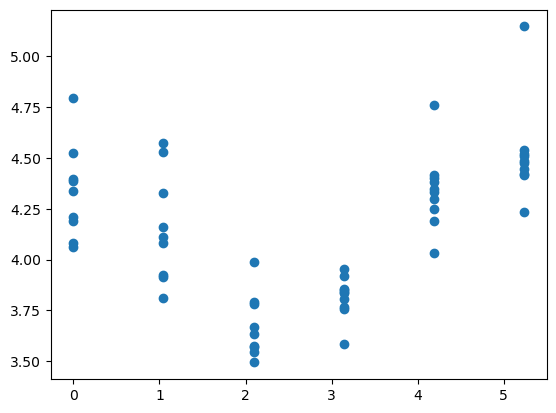

In [103]:
plt.plot(true_phases,NNshifted_phiC,'o')

In [104]:
sum((true_phases-NNshifted_phiC)**2)

290.39881880075876

Outliers really impacat this way of mesuring the goodness of the fit

In [105]:
print('PCA ', sum((true_phases-PCAshifted_phi)**2) )
print('Linear NN ', sum((true_phases-NNshifted_phi)**2) )
print('Circular NN ', sum((true_phases-NNshifted_phiC)**2) )

PCA  248.51430633716265
Linear NN  302.7840867450931
Circular NN  290.39881880075876


MAD seems more appropriate


In [106]:
print('PCA ', madPCA )
print('Linear NN ', madNN )
print('circular NN ', madNNC )

PCA  0.33878580216854104
Linear NN  0.8635016232681889
Linear NN  0.8190286182778248
